# Practica 2 Bloque 2
### Predicción ingredientes de la semana con limipieza de datos de la Pizzería Maven Pizzas
Lara Ocón Madrid - 202115710


En esta práctica vamos a tomar los datos de la pizzería Maven Pizzas y calcular para cada semana del año la cantidad de cada ingrediente que se ha necesitado. 

Una vez obtenida la cantidad de cada ingrediente para cada semana, calcularemos la media de cada uno de ellos y multiplicaremos dicha media por 1.5 (valor que he decidido tomar para que no haya falta de ingredientes una semana).

Es decir, emplearemos una ETL, extrayendo los datos, transfromándolos para quedarnos con lo que necesitamos cada semana, y cargando dicha predicción en un csv.

A diferencia de la práctica anterior, en esta práctica debemos controlar que los datos estén "limpios". Por ello a la hora de trasnfromar los datos tendremos que eliminar Nans, arreglar nombres/números mal introducidos, cambiar caracteres en determinados dataframes por otros (por ejemplo: @ por a, 3 por e...)...

En resumen, estos son las reglas que vamos a aplicar para limpiar los datos:
1) en la columna quantity de order_details:
    - quitar las celdas vacías
    - cambiar los números ngeativos por su valor absoluto
    - cambiar los números introducidos alfabeticamente por su número (por ejemplo: one = 1)
    
2) en la columna pizza_id de order_details:
    - cambiar - por _
    - cambiar @ por a
    - cambiar 0 por o
    - cambiar " " por _
    - cambiar 3 por e

3) en la columna date de orders
    - quitar los nan/None
    - transformar fechas a formato datetime
    - quitar las que no son fechas o transformar las fechas introducidad en otro tipo de formato


In [102]:
# importamos las librerias necesarias
import pandas as pd
import datetime
import re
import numpy as np

### Funciones de extracción de datos

In [103]:
def extract(fichero):
    df = pd.read_csv(fichero, sep=";")
    return df

# Creamos una segunda función para leer los csv cuyos separadores
# sean comas (order_details.csv y orders.csv) 
def extract_2(fichero):
    df = pd.read_csv(fichero, sep=",")
    return df

### Funciones de transformación de datos

In [104]:
# En esta función vamos a limpiar el csv que contiene
# las orders que se han realizado cada día.
# De esta forma devolvemos el mismo csv, eliminando los nans, 
# corrigiendo número mal introducidos y cambiando el formato 
# de las fechas a datetime.

def transform_order_dates(df_order_dates):

    # vamos a contar cuantos nan y null por columna hay
    # vamos tambien a ver el tipo por columna
    print("Tipos de variables por columnas = \n", df_order_dates.dtypes)
    print("Numero de NaN por columnas = \n", df_order_dates.isna().sum()) # isnull tambien vale
    # con : df.isnull().sum(axis=1) vemos nulls por filas, axis=0 nulls por columnas

    # quitamos la columna de horas pues no nos interesa:
    # df_order_dates = df_order_dates.drop(['time'], axis=1)

    # ahora vamos a transformar las fechas, quitando aquellas que den error
    for i in range(len(df_order_dates)):
        try:
            df_order_dates.loc[i, 'date'] = pd.to_datetime(df_order_dates.loc[i, 'date'], dayfirst=True)
        except:
            fecha = datetime.datetime.fromtimestamp(float(df_order_dates.loc[i, 'date'])).date()
            # quiero que tenga el mismo formato
            df_order_dates.loc[i, 'date'] = pd.to_datetime(fecha)

    # Quitamos los nans
    df_order_dates = df_order_dates.dropna()

    # vamos a ordenar el dataframe por order_id
    df_order_dates = df_order_dates.sort_values('order_id')

    # reseteamos los index
    df_order_dates.reset_index(inplace=True, drop=True)

    return df_order_dates

In [105]:
df_order_dates = extract("ficheros_csv/orders.csv")
df_order_dates = transform_order_dates(df_order_dates)
df_order_dates.head()


Tipos de variables por columnas = 
 order_id     int64
date        object
time        object
dtype: object
Numero de NaN por columnas = 
 order_id       0
date        2353
time        2038
dtype: int64


,order_id,date,time
0,1,2016-01-01 00:00:00,11H 38M 36S
1,2,2016-01-01 11:57:40,00:00 AM
2,4,2016-01-01 00:00:00,12:16:31
3,5,2016-01-01 12:21:30,00:00 AM
4,6,2016-01-01 00:00:00,12:29:36


In [106]:
# La siguiente función tranforma el csv de los detalles de cada order
# para ello sustituye caracteres mal introducidos en los nombres de las
# pizzas como (@ por a) y sustituye los nans de la cantidad de pizzas pedidas
# por la media (1). Con los nans restantes, elimina dichas filas.
# Por último, ordena el dataframe por order_id y resetea los index.

def transform_order_details(df_order_details):
    # vamos a contar cuantos nan y null por columna hay
    # vamos tambien a ver el tipo por columna
    print("\nTipos de variables por columnas = ", df_order_details.dtypes)
    print("\nNumero de NaN por columnas = ", df_order_details.isna().sum()) # isnull tambien vale
    # con : df.isnull().sum(axis=1) vemos nulls por filas, axis=0 nulls por columnas

    # ahora cambiamos los one/One por unos y quitamos los numeros negativos
    # tambien cambiamos @ por a , - por _, 0 por o, " " por _ y 3 por e
    for i in range(len(df_order_details)):
        pizza_id = df_order_details.loc[i, 'pizza_id']
        cantidad = df_order_details.loc[i, 'quantity']
        try:
            pizza_id = re.sub(" ", "_", pizza_id)
            pizza_id = re.sub("@", "a", pizza_id)
            pizza_id = re.sub("-", "_", pizza_id)
            pizza_id = re.sub("0", "o", pizza_id)
            pizza_id = re.sub("3", "e", pizza_id)
        except:
            # esto es el caso de que sean Nan
            ... 
        
        try:
            cantidad = int(cantidad)
            if cantidad < 0:
                cantidad = -cantidad
                # ponemos las cantidades en positivo
                #eliminar_filas = eliminar_filas.append(i)
        except:
            if cantidad in ["one", "One"]:
                cantidad = 1
            elif cantidad in ["two", "Two"]:
                cantidad = 2
                
        df_order_details.loc[i, 'pizza_id'] = pizza_id
        df_order_details.loc[i, 'quantity'] = cantidad

    # cambiamos los Nans de cuantity por la media
    df_order_details['quantity'] = df_order_details['quantity'].fillna(value=int(df_order_details['quantity'].mean()))
    # quitamos todos los nans sobrantes (columna de pizzas)
    df_order_details = df_order_details.dropna()
    df_order_details.reset_index(inplace=True, drop=True)

    # ordenamos por order_id
    df_order_details = df_order_details.sort_values('order_id')
    # volvemos a poner los index
    df_order_details.reset_index(inplace=True, drop=True)

    return df_order_details

In [107]:
# Ahora extraemos y transformamos el csv de order_details
df_order_details = extract("ficheros_csv/order_details.csv")
df_order_details = transform_order_details(df_order_details)
df_order_details.head()


Tipos de variables por columnas =  order_details_id     int64
order_id             int64
pizza_id            object
quantity            object
dtype: object

Numero de NaN por columnas =  order_details_id       0
order_id               0
pizza_id            5673
quantity            4726
dtype: int64


,order_details_id,order_id,pizza_id,quantity
0,1,1,hawaiian_m,1
1,5,2,mexicana_m,1
2,3,2,five_cheese_l,1
3,2,2,classic_dlx_m,1
4,6,2,thai_ckn_l,1


In [108]:
# creamos una función que devuelva una lista que contenga
# para cada semana su rango de orders. Es decir, las orders 
# están enumeradas por un identificador, el cual va en orden
# ascendente. Por lo que solo con el limite inferior y superior
# de cada semana podemos saber que orders corresponden a cada semana

def extraer_rango_orders_semana(df_order_dates):

    # Para crear el rango de cada semana, buscaremos la primera order
    # de cada semana y la ultima order de cada semana. Como las orders
    # están numeradas en orden ascendente, para la primera solo tenemos
    # que buscar el minimo de esa semana, y para la ultima el maximo.
    orders_semanas = [[np.inf, -np.inf] for t in range(53)]

    # veo que dia de la semana es el 1 de enero de 2016, esto lo necesitamos
    # para la operacion que calcula que dia de la semana es una fecha determinada
    primer_dia_semana = pd.to_datetime("01-01-2016").dayofweek

    i = 0
    while i < len(df_order_dates):
        orders_semana = orders_semanas[(df_order_dates.loc[i, 'date'].day_of_year + primer_dia_semana) // 7]
        if (df_order_dates.loc[i, 'order_id']) > orders_semana[1]:
            orders_semana[1] = df_order_dates.loc[i, 'order_id']
        if (df_order_dates.loc[i, 'order_id']) < orders_semana[0]:
            orders_semana[0] = df_order_dates.loc[i, 'order_id']
        
        orders_semanas[(df_order_dates.loc[i, 'date'].day_of_year + primer_dia_semana) // 7] = orders_semana
        
        i +=1 

    return orders_semanas


In [109]:
# Extraemos los rangos de orders por semana
orders_semanas = extraer_rango_orders_semana(df_order_dates)
print(orders_semanas)


[[1, 134], [137, 564], [566, 973], [976, 1389], [1390, 1791], [1792, 2240], [2242, 2665], [2666, 3077], [3078, 3471], [3473, 3812], [3814, 4227], [4228, 4660], [4661, 5061], [5062, 5499], [5500, 5912], [5913, 6324], [6326, 6748], [6750, 7169], [7170, 7578], [7579, 8014], [8015, 8443], [8444, 8843], [8846, 9260], [9261, 9689], [9692, 10100], [10101, 10509], [10510, 10924], [10925, 11398], [11399, 11809], [11812, 12244], [12245, 12662], [12664, 13089], [13090, 13510], [13511, 13943], [13944, 14345], [14347, 14739], [14742, 15153], [15155, 15590], [15591, 15940], [15943, 16316], [16317, 16660], [16662, 17046], [17047, 17386], [17387, 17746], [17747, 18145], [18146, 18557], [18558, 18950], [18951, 19401], [19402, 19846], [19848, 20270], [20271, 20693], [20694, 21106], [21107, 21349]]


In [110]:
# Creamos una función que nos devuelva un df con el numero de 
# pizzas de cada tipo que se han pedido en cada semana

def pizzas_por_semana(orders_semanas, df_order_details, pizzas_id):
    # Esta función recibe la lista que contiene los rangos de las orders
    # por semana (orders_semanas), el df con los detalles de las orders para 
    # cada semana (df_order_details) y una lista con todas las pizzas.

    df_pizzas_semana = pd.DataFrame()               # creamos el dataframe
    datos = {}
    for i in range(53):                             # creamos los indices del dataframe
        datos[f'semana {i}'] = [0 for i in range(len(pizzas_id))] # inicializamos la cantidad de cada pizza en 0
    df_pizzas_semana = pd.DataFrame(datos, index=pizzas_id) 

    i = 0
    semana = 0                                      # empezamos en la semana 0
    while semana < len(orders_semanas) and i < len(df_order_details):
        # buscamos la primera order de la semana correspondiente
        while (i < len(df_order_details)) and (df_order_details.loc[i, 'order_id'] < orders_semanas[semana][0]):
            i += 1
        # en el momento que lo encontramos, empezamos a añadir las pizzas hasta
        # salir del rango de orders de esa semana
        while (i < len(df_order_details)) and (df_order_details.loc[i, 'order_id'] <= orders_semanas[semana][1]):
            pizza, cantidad = obtener_nombre_y_can_pizza(df_order_details.iloc[i])
            df_pizzas_semana.loc[pizza, f'semana {semana}'] += cantidad
            i += 1
        semana += 1           # hemos terminado, pasamos a la siguiente semana
    
    return df_pizzas_semana


# Dado que en order details, además del id de pizza que se pide tenemos el tamaño
# de dicha pizza, y la cantidad de pizzas que se piden, vamos a crear una función
# que interprete para cada tamaño de pizza, cuantas pizzas se corresponden a un 
# tamaño de pizza "normal" y lo multiplique por la cantidad de dicha pizza.
# Esto nos servirá a la hora de calcular los ingredientes necesarios puesto que 
# no es lo mismo los ingredientes necesarios para una pizza xxl que una m.
# Como los tamaños van de s a xxl usaremos la siguiente correspondencia:
# s = 1, m = 1.5, l = 2, xl = 2.5, xxl = 3

def obtener_nombre_y_can_pizza(order):
    # añado la pizza asociada a ese order
    pizza = order['pizza_id']
    tam = 3
    # vemos su tamaño
    if re.search("_s$", pizza):
        pizza = re.sub("_s$","", pizza)
        tam = 1
    elif re.search("_m$", pizza):
        pizza = re.sub("_m$","", pizza)
        tam = 1.5
    elif re.search("_l$", pizza):
        pizza = re.sub("_l$","", pizza)
        tam = 2
    elif re.search("_xl$", pizza):
        pizza = re.sub("_xl$","", pizza)
        tam = 2.5
    elif re.search("_xxl$", pizza):
        pizza = re.sub("_xxl$","", pizza)
        tam = 3
    
    cantidad = order['quantity']
    
    return pizza, cantidad*tam

In [111]:
# Calculamos cuantas porciones de cada pizza se han pedido en cada semana.
# Para ello, vamos a guardarnos en una lista los nombres de las pizzas, pues este será
# el indice de nuestro dataframe
df_pizza_types = extract_2('ficheros_csv/pizza_types.csv')
pizzas_id = list(df_pizza_types['pizza_type_id'])

df_pizzas_semana = pizzas_por_semana(orders_semanas, df_order_details, pizzas_id)
df_pizzas_semana.head()


,semana 0,semana 1,semana 2,semana 3,semana 4,semana 5,semana 6,semana 7,semana 8,semana 9,...,semana 43,semana 44,semana 45,semana 46,semana 47,semana 48,semana 49,semana 50,semana 51,semana 52
bbq_ckn,29.0,58.0,61.5,73.5,79.0,79.0,77.0,64.0,65.0,55.5,...,38.5,60.5,76.5,73.0,69.0,86.0,49.0,77.0,58.0,41.0
cali_ckn,12.5,65.0,55.0,83.0,46.0,76.5,64.5,69.0,67.0,69.0,...,53.5,69.5,76.5,54.5,63.0,67.5,70.5,80.5,70.0,38.5
ckn_alfredo,2.5,49.0,15.5,22.0,28.5,22.5,30.0,23.0,20.5,23.0,...,24.0,28.0,46.5,30.5,16.5,28.0,32.5,23.5,26.5,12.5
ckn_pesto,10.5,28.5,27.0,25.0,21.5,19.5,33.5,44.0,28.0,12.5,...,14.0,36.0,27.5,32.5,15.5,35.0,20.0,26.5,27.5,16.5
southw_ckn,19.0,38.5,68.5,36.5,35.0,51.0,52.5,68.5,49.5,69.5,...,46.0,58.0,71.5,57.0,59.5,47.0,70.0,46.0,52.5,31.0


In [112]:
df_pizzas_semana.to_csv('ficheros_csv/pizzas_semana.csv')

In [113]:
# Ahora vamos a calcular los ingredientes necesarios cada semana.
# Para ello, creamos un diccionario con los ingredientes de cada pizza
# (esto hace que a la hora de buscar los ingredientes de cada pizza, la 
# busqueda sea más rápida) y luego vamos a recorrer el df de pizzas por 
# semana, multiplicando cada ingrediente necesario por la cantidad pedida 
# de cada tipo de pizza para cada semana.
# Las cantidades de ingredientes las iremos sumando a un dataframe que 
# contenga los ingredientes necesarios por semana.

def extraer_ingredientes(df):
    dic = {}
    for i in range(len(df)):
        pizza = df.iloc[i]
        clave = pizza['pizza_type_id']
        ingredientes = pizza['ingredients'].strip().split(", ")
        dic[clave] = ingredientes
    return dic


def extraer_ingredientes_semanas(df_ingredientes_semanas, df_pizzas_semana, dic_ingredientes):
    for pizza in df_pizzas_semana.index:
        
        ingredientes = dic_ingredientes[pizza]

        for j in range(len(df_ingredientes_semanas)):
            # voy recorriendo las filas del df de ingredientes (semanas) y obtengo cuantas pizzas
            # de ese tipo se hacen cada semana
            num = df_pizzas_semana.loc[pizza, f"semana {j}"]
            # añado el numero a cada ingrediente
            for ingrediente in ingredientes:
                df_ingredientes_semanas.loc[f"semana {j}", ingrediente] += num
            
    return df_ingredientes_semanas

In [114]:
# Creamos el diccionario de ingredientes:
dic_ingredientes = extraer_ingredientes(df_pizza_types)

# Creamos el dataframe que contendrá la cantidad necesaria de cada ingrediente
# para cada semana

total_ingredientes = []
datos = {}
for ingredientes in  list(dic_ingredientes.values()) :
    for ingrediente in ingredientes:
        if ingrediente not in total_ingredientes:
            total_ingredientes.append(ingrediente)
            datos[ingrediente] = [0 for i in range(53)]

semanas = [f"semana {i}" for i in range(53)]

# ahora creamos un dataframe con los ingredientes de cada semana
df_ingredientes_semanas = pd.DataFrame(datos, index=semanas)

df_ingredientes_semanas.head()

,Barbecued Chicken,Red Peppers,Green Peppers,Tomatoes,Red Onions,Barbecue Sauce,Chicken,Artichoke,Spinach,Garlic,...,Smoked Gouda Cheese,Romano Cheese,Blue Cheese,Ricotta Cheese,Gorgonzola Piccante Cheese,Parmigiano Reggiano Cheese,Eggplant,Zucchini,Sun-dried Tomatoes,Plum Tomatoes
semana 0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
semana 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
semana 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
semana 3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
semana 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
# Calculamos la cantidad de ingredientes que se han necesitado cada semana
df_ingredientes_semanas = extraer_ingredientes_semanas(df_ingredientes_semanas, df_pizzas_semana, dic_ingredientes)
df_ingredientes_semanas.head()

,Barbecued Chicken,Red Peppers,Green Peppers,Tomatoes,Red Onions,Barbecue Sauce,Chicken,Artichoke,Spinach,Garlic,...,Smoked Gouda Cheese,Romano Cheese,Blue Cheese,Ricotta Cheese,Gorgonzola Piccante Cheese,Parmigiano Reggiano Cheese,Eggplant,Zucchini,Sun-dried Tomatoes,Plum Tomatoes
semana 0,29.0,164.5,50.0,275.5,194.5,29.0,69.5,12.5,75.0,257.0,...,18,18,18,14.5,14.5,14.5,7.5,19.0,13.0,7.0
semana 1,58.0,437.5,121.5,706.0,527.5,58.0,245.0,65.0,273.5,775.0,...,60,60,60,64.0,64.0,64.0,27.0,65.5,47.5,19.5
semana 2,61.5,422.0,135.0,782.0,558.5,61.5,224.5,55.0,261.0,805.5,...,54,54,54,47.5,47.5,47.5,22.0,67.5,49.0,19.5
semana 3,73.5,419.0,157.0,689.0,491.5,73.5,232.0,83.0,270.5,781.0,...,58,58,58,68.5,68.5,68.5,36.5,78.5,45.5,25.5
semana 4,79.0,438.0,138.0,692.5,513.0,79.0,192.5,46.0,213.0,716.5,...,42,42,42,54.5,54.5,54.5,31.0,63.5,47.0,22.0


In [116]:
df_ingredientes_semanas.to_csv('ficheros_csv/ingredientes_semana.csv')

In [117]:
# Finalmente, sabiendo la cantidad de ingredientes de cada tipo que hemos
# necesitado cada semana, podemos obtener la predicción. Para realizar dicha
# predicción, simplemente calculamos la media de cada ingrediente
# y multiplicamos dicha cantidad por 1.5, de esta forma evitamos que pueda 
# llegar a haber escasez de un determinado ingrediente una semana.

def obtener_prediccion_ingredientes(df_ingredientes_semanas):
    predicciones = df_ingredientes_semanas.mean()*1.5
    df_prediccion = pd.DataFrame(data=predicciones, columns=['cantidad'])
    return df_prediccion

In [118]:
# Calculamos la predicción
df_prediccion = obtener_prediccion_ingredientes(df_ingredientes_semanas)
df_prediccion.head()

,cantidad
Barbecued Chicken,97.995283
Red Peppers,656.136792
Green Peppers,204.608491
Tomatoes,1079.575472
Red Onions,785.320755


### Cargamos los datos

In [119]:
# Finalmente, solo nos queda pasar el dataframe de la prediccion, a un csv.

def cargar_predicciones(df_prediccion):
    # pasamos el dataframe a un csv
    df_prediccion.to_csv("ficheros_csv/predicciones.csv")

In [120]:
cargar_predicciones(df_prediccion)

### Empieza lo que es el bloque 4 (creamos mas dataframes)

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [122]:
df_pizzas_semana = pd.read_csv('ficheros_csv/pizzas_semana.csv', index_col=0)
df_pizzas_semana.head()

,semana 0,semana 1,semana 2,semana 3,semana 4,semana 5,semana 6,semana 7,semana 8,semana 9,...,semana 43,semana 44,semana 45,semana 46,semana 47,semana 48,semana 49,semana 50,semana 51,semana 52
bbq_ckn,29.0,58.0,61.5,73.5,79.0,79.0,77.0,64.0,65.0,55.5,...,38.5,60.5,76.5,73.0,69.0,86.0,49.0,77.0,58.0,41.0
cali_ckn,12.5,65.0,55.0,83.0,46.0,76.5,64.5,69.0,67.0,69.0,...,53.5,69.5,76.5,54.5,63.0,67.5,70.5,80.5,70.0,38.5
ckn_alfredo,2.5,49.0,15.5,22.0,28.5,22.5,30.0,23.0,20.5,23.0,...,24.0,28.0,46.5,30.5,16.5,28.0,32.5,23.5,26.5,12.5
ckn_pesto,10.5,28.5,27.0,25.0,21.5,19.5,33.5,44.0,28.0,12.5,...,14.0,36.0,27.5,32.5,15.5,35.0,20.0,26.5,27.5,16.5
southw_ckn,19.0,38.5,68.5,36.5,35.0,51.0,52.5,68.5,49.5,69.5,...,46.0,58.0,71.5,57.0,59.5,47.0,70.0,46.0,52.5,31.0


In [123]:
# veamos la media de las pizzas que se han pedido cada semana
df_media_pizza_semana = df_pizzas_semana.transpose().mean().sort_values(ascending=False)
df_media_pizza_semana.head()

thai_ckn     66.254717
bbq_ckn      65.330189
cali_ckn     61.669811
pepperoni    59.905660
hawaiian     59.358491
dtype: float64

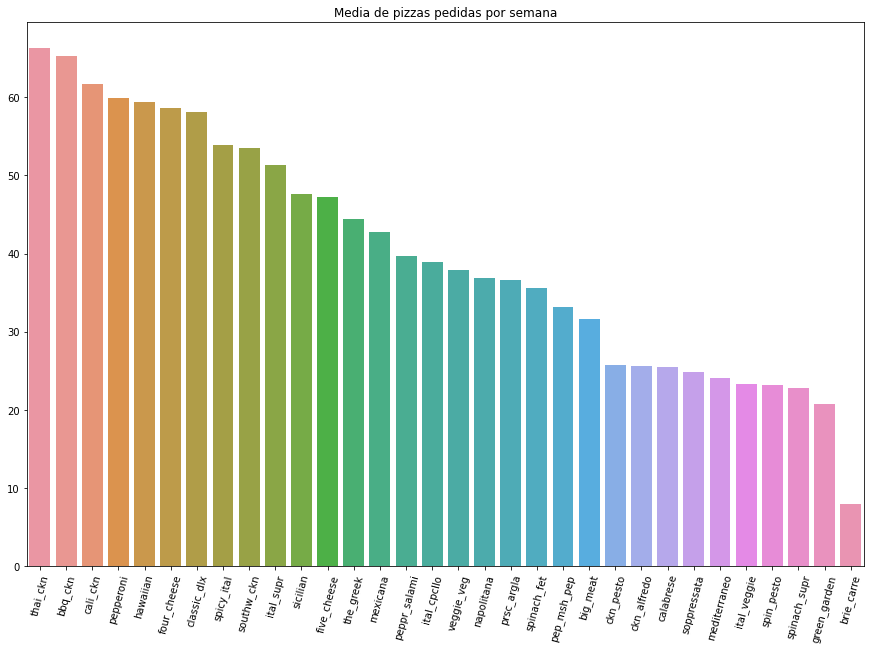

In [124]:
# vamos a hacer una grafica de las pizzas
plt.figure(figsize=(15, 10))
sns.barplot(x=df_media_pizza_semana.index, y=df_media_pizza_semana.values)
plt.xticks(rotation=75)
plt.title("Media de pizzas pedidas por semana")
plt.show()

In [125]:
# vamos a hacer un plot de a lo largo de las 53 semanas, como se han pedido las 5 mejores pizzas
# las top 5 pizzas son: thai_ckn, bbq_ckn, cali_ckn, pepperoni, hawaiian

# creamos un dataframe con las 5 mejores pizzas
df_top_5 = df_pizzas_semana.transpose()[['thai_ckn', 'bbq_ckn', 'cali_ckn', 'pepperoni', 'hawaiian']]
df_top_5.head()

,thai_ckn,bbq_ckn,cali_ckn,pepperoni,hawaiian
semana 0,25.0,29.0,12.5,23.0,18.0
semana 1,64.0,58.0,65.0,74.5,63.5
semana 2,58.5,61.5,55.0,76.5,42.0
semana 3,65.5,73.5,83.0,74.5,60.0
semana 4,61.5,79.0,46.0,57.5,47.0


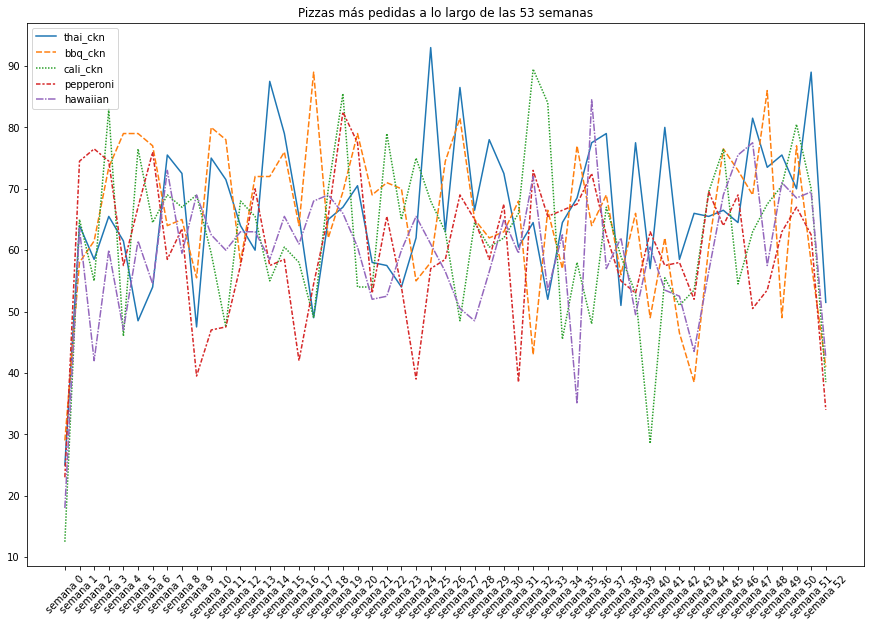

In [126]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=df_top_5)
plt.title("Pizzas más pedidas a lo largo de las 53 semanas")
plt.xticks(rotation=45)
plt.show()

In [127]:
# vamos a hacer un plot que vea para cada semana, si la prediccion de 1 ingrediente ha acertado
# o no. Para ello, vamos a coger el ingrediente que más se ha pedido cada semana y ver si
# la prediccion ha acertado o no.

# primero, vamos a coger el ingrediente que más se ha pedido cada semana
df_ingredientes_semanas = pd.read_csv('ficheros_csv/ingredientes_semana.csv', index_col=0)
df_ingredientes_semanas.head()

,Barbecued Chicken,Red Peppers,Green Peppers,Tomatoes,Red Onions,Barbecue Sauce,Chicken,Artichoke,Spinach,Garlic,...,Smoked Gouda Cheese,Romano Cheese,Blue Cheese,Ricotta Cheese,Gorgonzola Piccante Cheese,Parmigiano Reggiano Cheese,Eggplant,Zucchini,Sun-dried Tomatoes,Plum Tomatoes
semana 0,29.0,164.5,50.0,275.5,194.5,29.0,69.5,12.5,75.0,257.0,...,18,18,18,14.5,14.5,14.5,7.5,19.0,13.0,7.0
semana 1,58.0,437.5,121.5,706.0,527.5,58.0,245.0,65.0,273.5,775.0,...,60,60,60,64.0,64.0,64.0,27.0,65.5,47.5,19.5
semana 2,61.5,422.0,135.0,782.0,558.5,61.5,224.5,55.0,261.0,805.5,...,54,54,54,47.5,47.5,47.5,22.0,67.5,49.0,19.5
semana 3,73.5,419.0,157.0,689.0,491.5,73.5,232.0,83.0,270.5,781.0,...,58,58,58,68.5,68.5,68.5,36.5,78.5,45.5,25.5
semana 4,79.0,438.0,138.0,692.5,513.0,79.0,192.5,46.0,213.0,716.5,...,42,42,42,54.5,54.5,54.5,31.0,63.5,47.0,22.0


In [128]:
df_prediccion = pd.read_csv('ficheros_csv/predicciones.csv', index_col=0).transpose()
#df_prediccion.head()
# vamos a dividir la prediccion por 1.5 y multiplicar por 1.2 (nos hemos pasado con la prediccion)
df_prediccion = df_prediccion/1.5*1.2
df_prediccion.head()

,Barbecued Chicken,Red Peppers,Green Peppers,Tomatoes,Red Onions,Barbecue Sauce,Chicken,Artichoke,Spinach,Garlic,...,Smoked Gouda Cheese,Romano Cheese,Blue Cheese,Ricotta Cheese,Gorgonzola Piccante Cheese,Parmigiano Reggiano Cheese,Eggplant,Zucchini,Sun-dried Tomatoes,Plum Tomatoes
cantidad,78.396226,524.909434,163.686792,863.660377,628.256604,78.396226,279.316981,74.003774,302.116981,899.943396,...,56.739623,56.739623,56.739623,70.381132,70.381132,70.381132,27.950943,73.49434,56.683019,28.901887


In [129]:
# concatenamos los dos dataframes
df_concat = pd.concat([df_ingredientes_semanas, df_prediccion], axis=0)
df_concat.tail()

,Barbecued Chicken,Red Peppers,Green Peppers,Tomatoes,Red Onions,Barbecue Sauce,Chicken,Artichoke,Spinach,Garlic,...,Smoked Gouda Cheese,Romano Cheese,Blue Cheese,Ricotta Cheese,Gorgonzola Piccante Cheese,Parmigiano Reggiano Cheese,Eggplant,Zucchini,Sun-dried Tomatoes,Plum Tomatoes
semana 49,49.000000,484.000000,145.500000,793.500000,602.500000,49.000000,268.500000,70.500000,268.000000,834.000000,...,38.000000,38.000000,38.000000,66.000000,66.000000,66.000000,21.500000,77.50000,36.000000,21.000000
semana 50,77.000000,438.000000,152.500000,719.000000,529.500000,77.000000,246.500000,80.500000,301.000000,733.500000,...,28.000000,28.000000,28.000000,41.500000,41.500000,41.500000,30.000000,76.00000,59.500000,37.500000
semana 51,58.000000,458.000000,121.000000,703.500000,487.000000,58.000000,265.500000,70.000000,262.500000,697.500000,...,32.000000,32.000000,32.000000,54.500000,54.500000,54.500000,33.500000,65.50000,62.500000,39.000000
semana 52,41.000000,311.000000,105.000000,493.000000,345.000000,41.000000,150.000000,38.500000,170.500000,519.500000,...,24.000000,24.000000,24.000000,59.500000,59.500000,59.500000,11.500000,52.00000,33.000000,11.500000
cantidad,78.396226,524.909434,163.686792,863.660377,628.256604,78.396226,279.316981,74.003774,302.116981,899.943396,...,56.739623,56.739623,56.739623,70.381132,70.381132,70.381132,27.950943,73.49434,56.683019,28.901887


In [130]:
# le restamos a todas las filas la ultima fila
df_concat = df_concat.iloc[-1] - df_concat.iloc[:-1]
#df_concat.loc[:'semana 52'].tail() 
print("Como vemos siempre sobran ingredientes")
df_concat.tail()


Como vemos siempre sobran ingredientes


,Barbecued Chicken,Red Peppers,Green Peppers,Tomatoes,Red Onions,Barbecue Sauce,Chicken,Artichoke,Spinach,Garlic,...,Smoked Gouda Cheese,Romano Cheese,Blue Cheese,Ricotta Cheese,Gorgonzola Piccante Cheese,Parmigiano Reggiano Cheese,Eggplant,Zucchini,Sun-dried Tomatoes,Plum Tomatoes
semana 48,-7.603774,11.409434,-4.813208,76.660377,51.256604,-7.603774,28.316981,6.503774,30.616981,82.443396,...,10.739623,10.739623,10.739623,-1.118868,-1.118868,-1.118868,1.450943,5.49434,1.183019,4.901887
semana 49,29.396226,40.909434,18.186792,70.160377,25.756604,29.396226,10.816981,3.503774,34.116981,65.943396,...,18.739623,18.739623,18.739623,4.381132,4.381132,4.381132,6.450943,-4.00566,20.683019,7.901887
semana 50,1.396226,86.909434,11.186792,144.660377,98.756604,1.396226,32.816981,-6.496226,1.116981,166.443396,...,28.739623,28.739623,28.739623,28.881132,28.881132,28.881132,-2.049057,-2.50566,-2.816981,-8.598113
semana 51,20.396226,66.909434,42.686792,160.160377,141.256604,20.396226,13.816981,4.003774,39.616981,202.443396,...,24.739623,24.739623,24.739623,15.881132,15.881132,15.881132,-5.549057,7.99434,-5.816981,-10.098113
semana 52,37.396226,213.909434,58.686792,370.660377,283.256604,37.396226,129.316981,35.503774,131.616981,380.443396,...,32.739623,32.739623,32.739623,10.881132,10.881132,10.881132,16.450943,21.49434,23.683019,17.401887


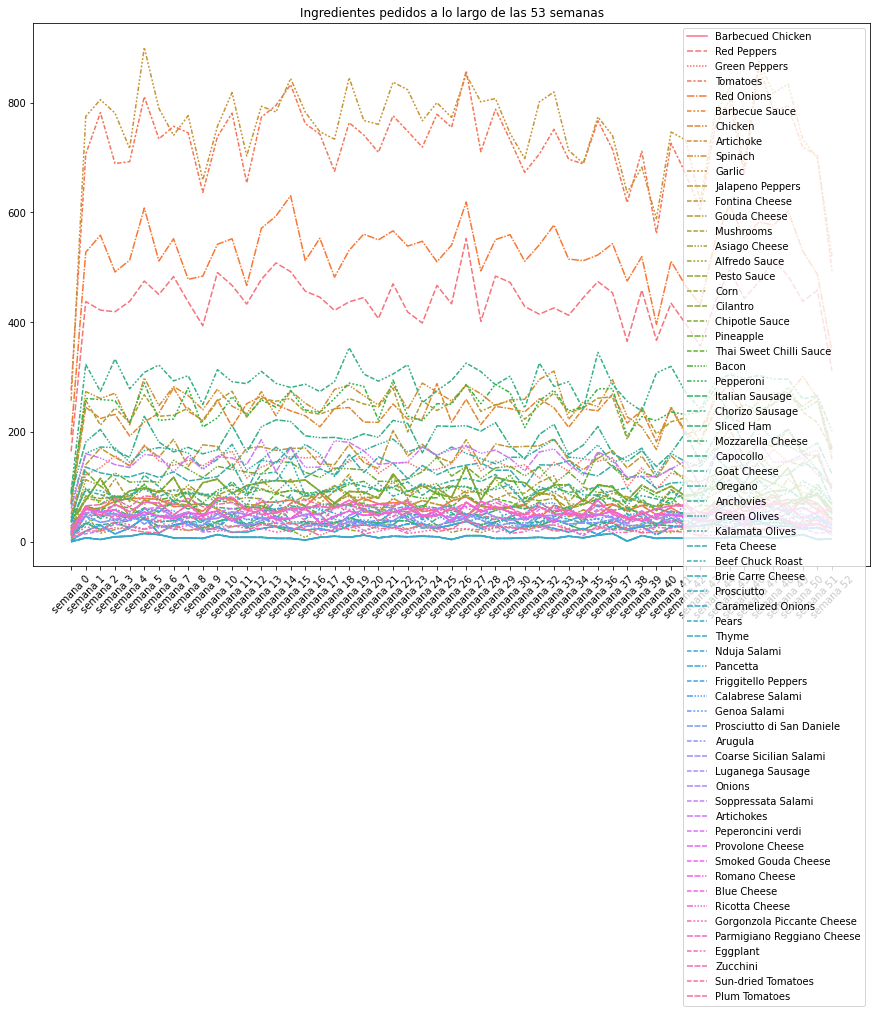

In [131]:

plt.figure(figsize=(15, 10))
sns.lineplot(data=df_ingredientes_semanas)
plt.title("Ingredientes pedidos a lo largo de las 53 semanas")
plt.xticks(rotation=45)
# guardamos la imagen en un png
plt.savefig('imagenes/ingredientes_necesitados_semana.png')
plt.show()

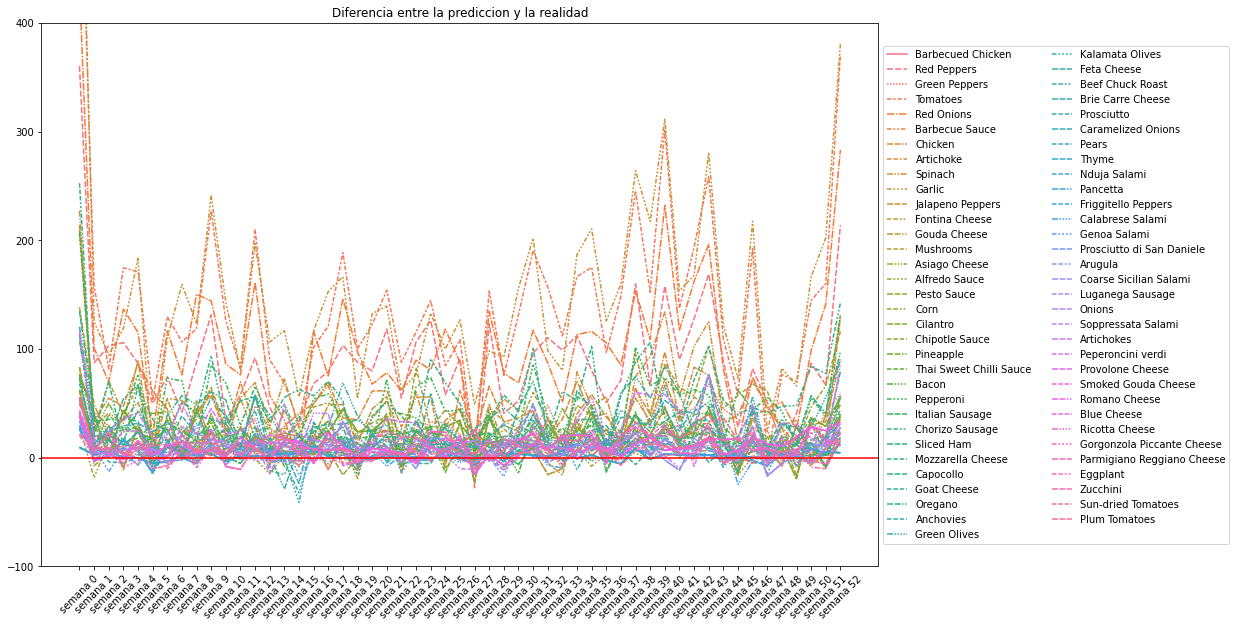

In [132]:
# ahora vemos las diferencias entre cada semana de la prediccion y la realidad
# vamos a poner una linea en el 0 para que se vea bien de los que faltan ingredientes

plt.figure(figsize=(15, 10))
sns.lineplot(data=df_concat)
plt.axhline(y=0, color='r', linestyle='-')
# vamos a poner que la y solo vaya de -100 a 100
plt.ylim(-100, 400)
plt.title("Diferencia entre la prediccion y la realidad")
# vamos a poner la leyenda mas pequeña en dos columnas
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
#plt.legend(fontsize=8)
plt.xticks(rotation=45)
# guardamos la imagen en un png
plt.savefig('imagenes/diferencia_prediccion_realidad_ingredientes.png')
plt.show()

In [133]:
# vamos a pintar el igrediente mas usado, para ver si la prediccion ha acertado o no
# vamos a coger el ingrediente que más se ha pedido cada semana
ingrediente_mas_usado = df_prediccion.idxmax(axis=1)
print(f"EL ingrediente mas necesitado es el {list(ingrediente_mas_usado)[0]}.")

EL ingrediente mas necesitado es el Garlic.


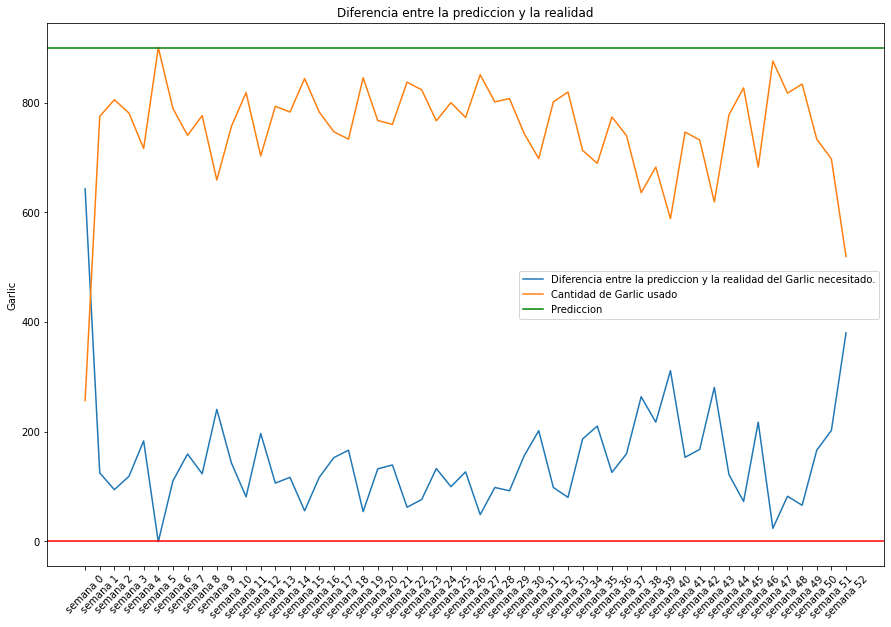

In [134]:
# vamos a ver para cada semana como ha ido la prediccion con la cantidad de Garlic usado

plt.figure(figsize=(15, 10))
sns.lineplot(data=df_concat['Garlic'], label='Diferencia entre la prediccion y la realidad del Garlic necesitado.')
sns.lineplot(data=df_ingredientes_semanas['Garlic'], label='Cantidad de Garlic usado')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=df_prediccion['Garlic'].max(), color='g', linestyle='-', label="Prediccion")
# vamos a poner que la y solo vaya de -100 a 100
#plt.ylim(-100, 100)
plt.title("Diferencia entre la prediccion y la realidad")
plt.xticks(rotation=45)
plt.legend()
plt.savefig('imagenes/diferencia_prediccion_realidad_Garlic.png')
plt.show()

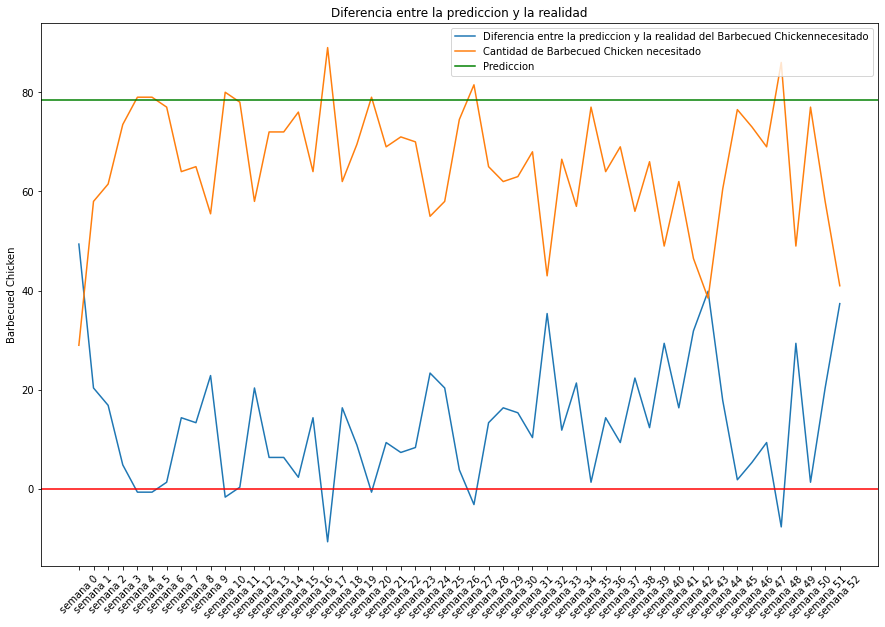

In [135]:
# hacemos lo mismo para el Barbecued Chicken
plt.figure(figsize=(15, 10))
sns.lineplot(data=df_concat['Barbecued Chicken'], label='Diferencia entre la prediccion y la realidad del Barbecued Chickennecesitado')
sns.lineplot(data=df_ingredientes_semanas['Barbecued Chicken'], label='Cantidad de Barbecued Chicken necesitado')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=df_prediccion['Barbecued Chicken'].max(), color='g', linestyle='-', label="Prediccion")
# vamos a poner que la y solo vaya de -100 a 100
#plt.ylim(-100, 100)
plt.title("Diferencia entre la prediccion y la realidad")
plt.xticks(rotation=45)
plt.legend()
plt.savefig('imagenes/diferencia_prediccion_realidad_Barbecued_Chicken.png')
plt.show()

In [136]:
# vamos a hacer un grafico de barras con la lista de la compra


x = list(df_prediccion.transpose().index)
y = list(df_prediccion.transpose().values)
dic = {}
for i in range(len(x)):
    dic[x[i]] = int(y[i])
# ordenamos el diccionario por y

dic = sorted(dic.items(), key=lambda x: x[1], reverse=True)
x = np.array([i[0] for i in dic])
y = np.array([i[1] for i in dic])



[]

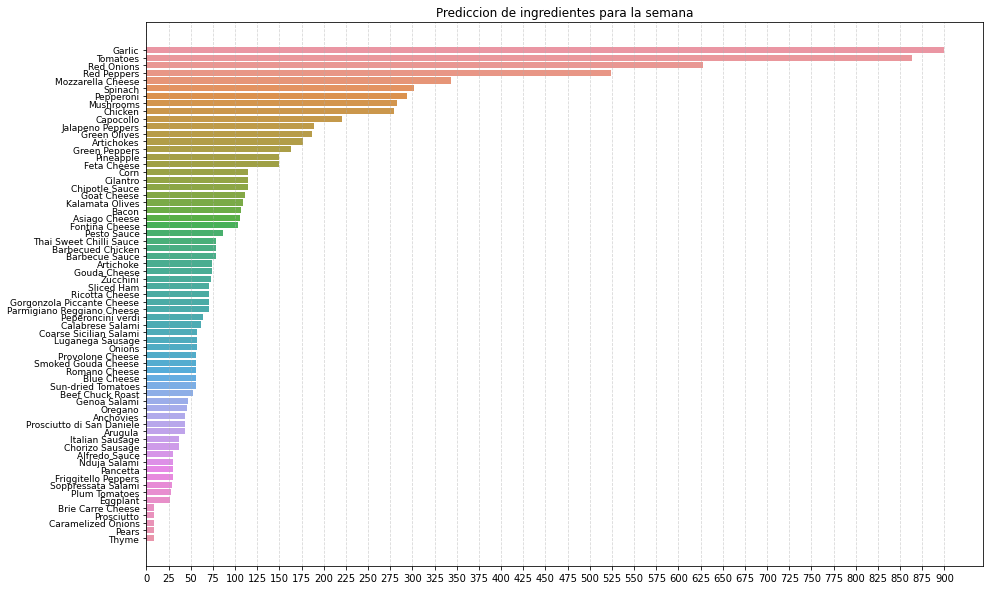

In [137]:
# vamos a hacer un barplot donde la leyenda es x y las barras son y
plt.figure(figsize=(15, 10))
sns.barplot(x=y, y=x)
# vamos a poner las labels de la y que se vean mejor
plt.yticks(size=9)
# vamos a poner grid vertical
# queremos que se vean mas valores sobre la x
plt.xticks(np.arange(0, 925, 25))
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.title("Prediccion de ingredientes para la semana")
plt.savefig('imagenes/prediccion_ingredientes.png')
plt.plot()

In [138]:
# POr ultimo vamos a hacer un grafico que se vea el dinero ganado cada semana
# Para ello, tenemos que ver el tamaño de cada pizza y el precio para ese tamaño de pizza


# Creamos una función que nos devuelva un df con el numero de 
# pizzas de cada tipo que se han pedido en cada semana

df_pizzas = pd.read_csv('ficheros_csv/pizzas.csv') # este contiene el precio de cada pizza

def revenue_por_semana(orders_semanas, df_order_details, pizzas_id, df_pizzas):
    # Esta función recibe la lista que contiene los rangos de las orders
    # por semana (orders_semanas), el df con los detalles de las orders para 
    # cada semana (df_order_details) y una lista con todas las pizzas.

    df_revenue_semana = pd.DataFrame()               # creamos el dataframe
    datos = {}
    for i in range(53):                             # creamos los indices del dataframe
        datos[f'semana {i}'] = 0 # inicializamos la cantidad de cada pizza en 0
    df_pizzas_semana = pd.DataFrame(datos, index=['Revenue']) 

    i = 0
    semana = 0                                      # empezamos en la semana 0
    while semana < len(orders_semanas) and i < len(df_order_details):
        # buscamos la primera order de la semana correspondiente
        while (i < len(df_order_details)) and (df_order_details.loc[i, 'order_id'] < orders_semanas[semana][0]):
            i += 1
        # en el momento que lo encontramos, empezamos a añadir las pizzas hasta
        # salir del rango de orders de esa semana
        while (i < len(df_order_details)) and (df_order_details.loc[i, 'order_id'] <= orders_semanas[semana][1]):
            ganancia = obtener_ganancia(df_order_details.loc[i, 'pizza_id'], df_pizzas)
            df_pizzas_semana[f'semana {semana}'] += ganancia
            i += 1
        semana += 1           # hemos terminado, pasamos a la siguiente semana
    
    return df_pizzas_semana

def obtener_ganancia(order, df_pizzas):
    precio = df_pizzas.loc[df_pizzas['pizza_id'] == order, 'price'].values[0]
    # pasamos el precio a float
    return float(precio)


df_ganancias_semana = revenue_por_semana(orders_semanas, df_order_details, pizzas_id, df_pizzas)
df_ganancias_semana.head()

,semana 0,semana 1,semana 2,semana 3,semana 4,semana 5,semana 6,semana 7,semana 8,semana 9,...,semana 43,semana 44,semana 45,semana 46,semana 47,semana 48,semana 49,semana 50,semana 51,semana 52
Revenue,4538.5,13794.7,13396.15,13722.05,12801.6,15096.6,13793.8,13807.2,13612.05,11923.05,...,11068.05,14155.2,14765.45,12934.1,14996.6,14462.55,14622.75,13425.45,13308.8,8899.1


In [139]:
# vamos a crear un dataframe con las ganancias al mes
df_ganancias_mes = pd.DataFrame()
datos = {}
for i in range(0, 52, 4):
    datos[f'mes {i//4}'] = df_ganancias_semana[f'semana {i}'] + df_ganancias_semana[f'semana {i+1}'] + df_ganancias_semana[f'semana {i+2}'] + df_ganancias_semana[f'semana {i+3}']

df_ganancias_mes = pd.DataFrame(datos, index=['Revenue'])
df_ganancias_mes.head()

,mes 0,mes 1,mes 2,mes 3,mes 4,mes 5,mes 6,mes 7,mes 8,mes 9,mes 10,mes 11,mes 12
Revenue,45451.4,55499.2,53980.45,55795.45,54741.2,55805.85,56410.35,53991.95,54063.45,52584.6,47643.3,56851.35,55819.55


In [140]:
df_ganancias_mes_acumulado = df_ganancias_mes.cumsum(axis=1)
df_ganancias_mes_acumulado.head()

,mes 0,mes 1,mes 2,mes 3,mes 4,mes 5,mes 6,mes 7,mes 8,mes 9,mes 10,mes 11,mes 12
Revenue,45451.4,100950.6,154931.05,210726.5,265467.7,321273.55,377683.9,431675.85,485739.3,538323.9,585967.2,642818.55,698638.1


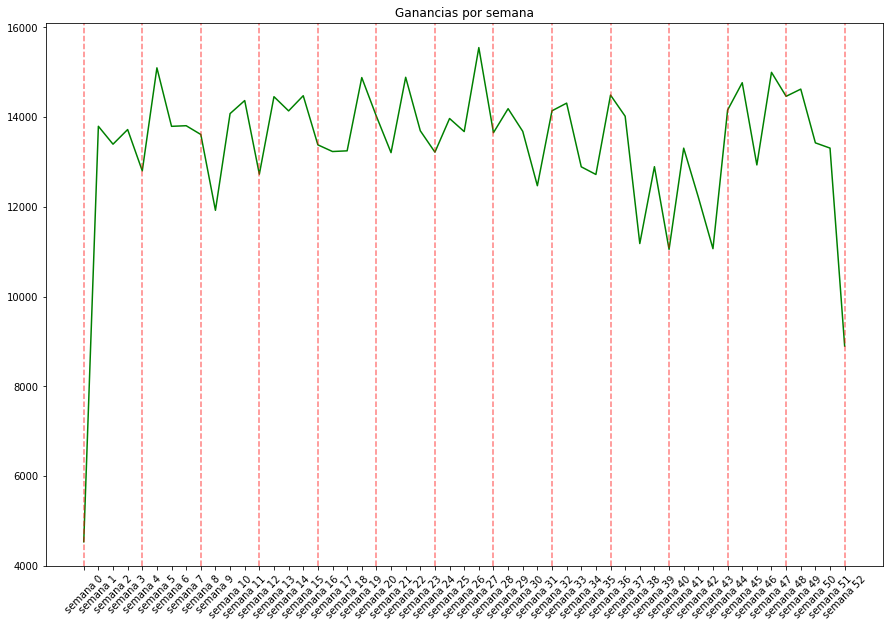

In [141]:
# vamos a hacer un grafico con las ganancias por semana
# vamos a ponerle algun color guay

plt.figure(figsize=(15, 10))
# queremos que empiece en la semana 0
plt.plot(df_ganancias_semana.columns, df_ganancias_semana.loc['Revenue'], color='g')
# vamos a marcar los meses
for i in range(0, 53, 4):
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.5)
# sns.lineplot(data=df_ganancias_semana.transpose())
#sns.lineplot(data=df_ganancias_semana.transpose().cumsum())
plt.title("Ganancias por semana")
plt.xticks(rotation=45)
plt.savefig('imagenes/ganancias_semana.png')
plt.show()

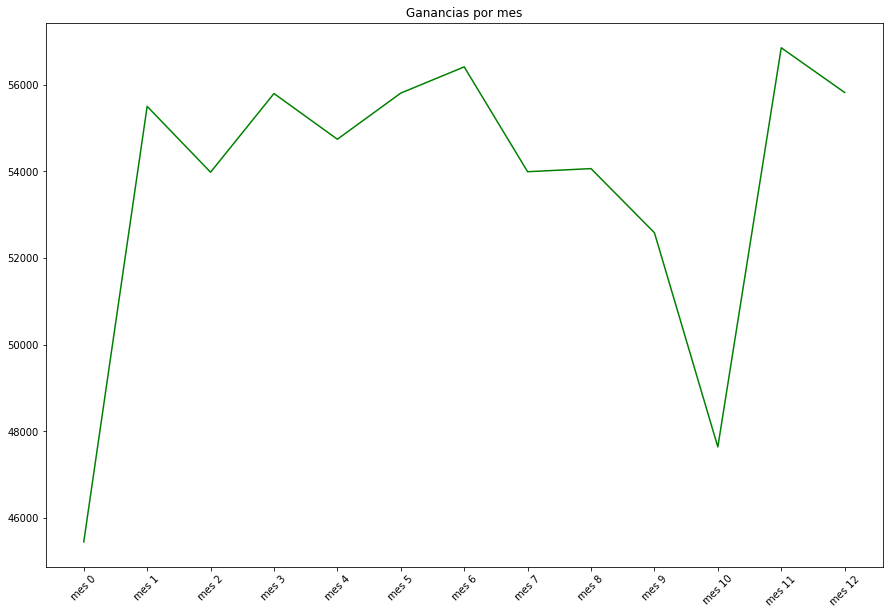

In [142]:
# ganancias por mes
plt.figure(figsize=(15, 10))
plt.plot(df_ganancias_mes.columns, df_ganancias_mes.loc['Revenue'], color='g')
plt.title("Ganancias por mes")
plt.xticks(rotation=45)
plt.savefig('imagenes/ganancias_mes.png')
plt.show()
